# Causal.jl: A Modeling and Simulation Framework for Causal Models
## Answers to the Questions/Comments

We would like to thank Yingbo Ma for contributing to our study with his valuable comments. The text was reviewed accordingly. Below are the specific answers to the questions/comments.

1. **Could you write a bit more on the connection between the sampling by the model clock and the time stepping of the differential equation solvers?**

It is possible for the users to determine the time instants at which the components are sampled. The user-specified sampling time instants can be spaced regularly or irregularly. However, although the sampling time instants are determined by the user, the solvers of the systems take adaptive steps while the systems evolve from one sampling instant to the next. Therefore, the sampling time instants determined by the user do not force the systems to evolve with specified time intervals but to sample the outputs of the systems at those specified instants.

*Note: The text is revised to include this paragraph in Section 2.4 Simulation* 

2. **There are a few times where the space before the open parenthesis is missing:**

    The white spaces before the open parenthesis are inserted. 

3. **Do the strategies of breaking up algebraic loops suggested in Section 2.4 compromise the accuracy of the model?**

Consider following model 

<img src="./algebraicloop.svg" width="50%"  align="center"/>

The model consists of a signal generator `gen`, and adder `adder`, gain `gain`. The writers `writerin` and `writerout` are used to record signals $r(t)$ and $y(t)$. The relation between the signals $r(t)$ and $u(t)$ and $y(t)$ are 
$$
\begin{aligned} 
    u(t) &= r(t) - y(t) \\ 
    y(t) &= \alpha u(t)
\end{aligned}
$$
where $\alpha$ is the gain of `gain`. Solving these equation, we find
$$
    y(t) = \dfrac{\alpha}{\alpha + 1} r(t)
$$

Model simulation in `Causal.jl` is performed in a series of stages, namely, inspection, initialization, run and termination. In the inspection stage, the model is inspected to see if the model is suitable for the simulation. Detection of algebraic loops is among the inspections performed in the inspection stage of the simulation. In case an algebraic loop is detected, it is reported in the logs of the simulation. Furthermore, if it is possible (for example, if the loops are net nested), `Causal.jl` breaks the loops automatically. Otherwise, it informs the user to revise the model such that the algebraic loops are eliminated from the model. To break a detected loop, a loop equation in the form of 
$$
    h(y_i) = 0
$$
is constructed corresponding to the loop. Here, the loop variable $y_i = y(t_i)$, where $t_i$ is the $i$-th step of the simulation and $y(t)$ is the signal to be sampled. For example, the loop equation for the algebraic loop given in the above model is 
$$
h(y_i) = (α + 1) y_i - \alpha r_i = 0
$$
where $r_i = r(t_i)$. The loop equation is solved numerically via a root-finding algorithm. `Causal.jl` uses [`NLsolve.nlsolve`](https://github.com/JuliaNLSolvers/NLsolve.jl). The root-finding algorithm computes the root of the loop equation with a certain error. Thus, `Causal.jl` breaks algebraic loops automatically at the expense of a certain numerical error of the root-finding algorithm. To see the effect of root-finding algorithm on the accuracy of the simulation, let us simulate the model given above.

[ Info: 2021-07-03T14:05:40.114 Started simulation...
[ Info: 2021-07-03T14:05:40.114 Inspecting model...
┌ Info: 	The model has algrebraic loops:[[2, 3]]
└ 		Trying to break these loops...
[ Info: 	Loop [2, 3] is broken
[ Info: 2021-07-03T14:05:40.116 Done.
[ Info: 2021-07-03T14:05:40.116 Initializing the model...
[ Info: 2021-07-03T14:05:40.134 Done...
[ Info: 2021-07-03T14:05:40.134 Running the simulation...
[ Info: 2021-07-03T14:05:40.139 Done...
[ Info: 2021-07-03T14:05:40.140 Terminating the simulation...
[ Info: 2021-07-03T14:05:40.146 Done.


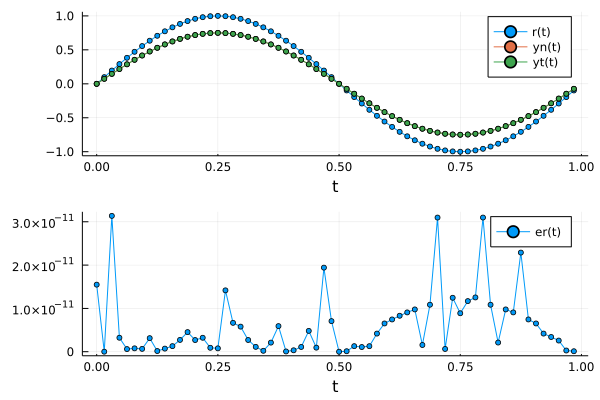

In [2]:
# Load packages 
using Causal 
using Plots 

# Model construction 
α = 3. 
@defmodel model begin
    @nodes begin
        gen   = SinewaveGenerator()
        adder = Adder(signs=(+,-))
        gain  = Gain(gain = α)
        writerout = Writer()
        writerin  = Writer()
    end
    @branches begin
        gen[1]   => adder[1]
        adder[1] => gain[1]
        gain[1]  => adder[2]
        gen[1]   => writerin[1]
        gain[1]  => writerout[1]
    end
end

# Simulation 
ti, dt, tf = 0., 1 / 64., 1.
sim = simulate!(model, ti, dt, tf)

# Reading the simulation data
t, r = getcomponent(model, :writerin) |> read 
t, yn = getcomponent(model, :writerout) |> read     # Numerical solution 

# Computing simulation error 
yt = α / (α + 1) * r    # Theoretical solution 
er = abs.(yn - yt)      # Absolute error 

# Plots 
plt = plot(layout=(2, 1), xlabel="t")
plot!(t, r,  label="r(t)",  marker=(:circle, 3), subplot=1)
plot!(t, yt, label="yn(t)", marker=(:circle, 3), subplot=1)
plot!(t, yt, label="yt(t)", marker=(:circle, 3), subplot=1)
plot!(t, er, label="er(t)", marker=(:circle, 3), subplot=2) 

Note from the simulation results that the error between the numerical and theoretical values of $y(t)$ is very small and acceptable (of course maybe not for very sensitive applications) in the realm of numerical computing.